**Author:** Zhenyu Zhou   
**Topic:** Hack4Space 2021  
**Created:** 7 May 2021  

# Understanding the data format

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import *

# Testing Time Series zhenyu's code

In [58]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA # deprecated
from statsmodels.tsa.arima.model import ARIMA

In [59]:
columns = ['Date', 'Time', 'Lat', 'Long', 'Dust', 'Dust_Err', 'H20ice', 'H20_iceErr']
df = pd.read_csv('parserData (1).csv', names=columns)
df['TS'] = df['Date'] + '\t' + df['Time']
df['TS'] = pd.to_datetime(df['TS'],)
df = df.set_index('TS')
df['Hour'] = df.index.hour
df.head()

,Date,Time,Lat,Long,Dust,Dust_Err,H20ice,H20_iceErr,Hour
TS,,,,,,,,,
2015-04-01 00:00:29.190,01-Apr-2015,00:00:29.190,76.926,11.539,3.527100e-06,0.000003,0.002969,0.000473,0
2015-04-01 00:00:29.190,01-Apr-2015,00:00:29.190,76.958,11.569,6.542500e-07,0.000001,0.003295,0.000390,0
2015-04-01 00:00:29.190,01-Apr-2015,00:00:29.190,76.989,11.599,1.788700e-07,0.000001,0.003487,0.000336,0
2015-04-01 00:00:29.190,01-Apr-2015,00:00:29.190,77.021,11.629,5.223300e-08,0.000001,0.003401,0.000305,0
2015-04-01 00:00:29.190,01-Apr-2015,00:00:29.190,77.052,11.659,1.393500e-08,0.000001,0.002850,0.000280,0


In [60]:
df_t = df.resample('1Min').mean()
df_t['Dust'].interpolate(method='time', inplace=True)
df_t
dust=df_t.drop(['Lat','Long','Dust_Err','H20ice','H20_iceErr','Hour'], axis=1)
dust.head()

,Dust
TS,
2015-04-01 00:00:00,4.031861e-07
2015-04-01 00:01:00,9.547337e-07
2015-04-01 00:02:00,2.263008e-09
2015-04-01 00:03:00,1.000000e-09
2015-04-01 00:04:00,1.000000e-09


In [61]:
dust = dust[dust.index > '2015-04-03'] # To skip missing days with NaNs
dust

,Dust
TS,
2015-04-03 00:01:00,2.815772e-04
2015-04-03 00:02:00,2.817487e-04
2015-04-03 00:03:00,2.819203e-04
2015-04-03 00:04:00,2.820919e-04
2015-04-03 00:05:00,2.822635e-04
...,...
2015-04-30 23:55:00,8.699489e-07
2015-04-30 23:56:00,9.224086e-07
2015-04-30 23:57:00,7.562364e-08


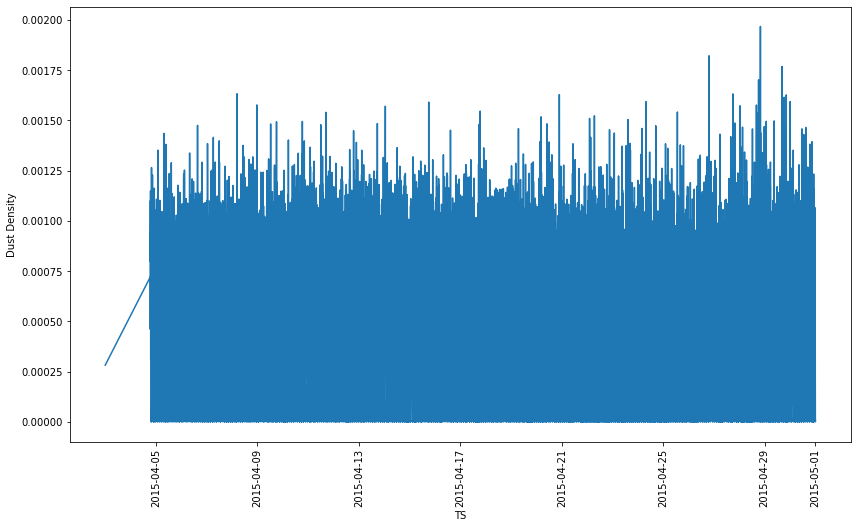

In [62]:
plt.figure(figsize=(14,8))
plt.xlabel('TS')
plt.ylabel('Dust Density')
plt.xticks(rotation=90)
plt.plot(dust)

In [63]:
from statsmodels.tsa.stattools import adfuller 

In [64]:
#test stationary 
print('Results of Dickey Fuller Test:')
dftest = adfuller(dust['Dust'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

#stationary 

Results of Dickey Fuller Test:
Test Statistic                   -32.973045
p-value                            0.000000
#Lags Used                        54.000000
Number of Observations Used    40264.000000
Critical Value (1%)               -3.430512
Critical Value (5%)               -2.861612
Critical Value (10%)              -2.566808
dtype: float64


In [214]:
from statsmodels.tsa.stattools import kpss

result = kpss(dust.Dust)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[3]['5%'])
print('p-value: %.2f' % result[1])

#not stationary 

(3.895345121645137, 0.01, 54, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 3.90
5% Critical Value: 0.46
p-value: 0.01


C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


# Auto regressive model

In [65]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

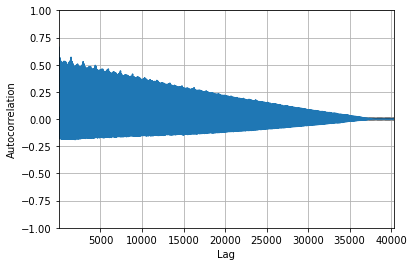

In [66]:
autocorrelation_plot(dust['Dust'])
plt.show()

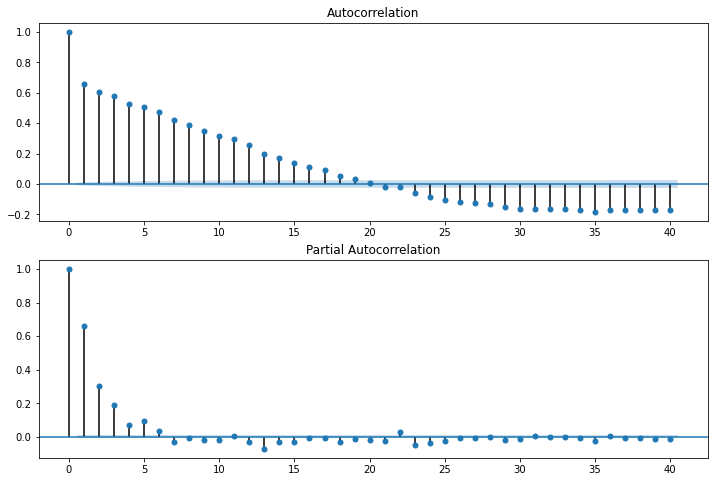

In [67]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dust['Dust'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dust['Dust'],lags=40,ax=ax2)

#MA model from ACF =3, OR 4
#AR model from PACF = 2


In [ ]:
#pip install pmdarima

In [79]:
from pmdarima import auto_arima
#stepwise_fit = auto_arima(dust['Dust'], trace=True,suppress_warnings=True)

In [69]:
#split data
#7:3
print(dust.shape)
train=dust.iloc[:-11663]
test=dust.iloc[-11663:]
print(train.shape,test.shape)

(40319, 1)
(28656, 1) (11663, 1)


In [70]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(train['Dust'],order=(2,1,4))
model=model.fit()
model.summary()

C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.Dust   No. Observations:                28655
Model:                 ARIMA(2, 1, 4)   Log Likelihood              201098.640
Method:                       css-mle   S.D. of innovations              0.000
Date:                Mon, 10 May 2021   AIC                        -402181.279
Time:                        17:05:35   BIC                        -402115.174
Sample:                    04-03-2015   HQIC                       -402160.022
                         - 04-22-2015                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9.754e-09   4.33e-07     -0.023      0.982   -8.58e-07    8.39e-07
ar.L1.D.Dust    -0.3475        nan        nan        nan         nan         nan
ar.L2.D.Dust    -0.2370        nan        nan        nan         nan         nan
ma.L1.D.Dust    -0.2444        nan        nan        nan         nan         nan
ma.L2.D.Dust    -0.0122        nan        nan        nan         nan         nan
ma.L3.D.Dust    -0.1439        nan        nan        nan         nan         nan
ma.L4.D.Dust    -0.0637        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7330           -1.9188j            2.0540           -0.3081
AR.2           -0.7330           +1.9188j            2.0540            0.3081
MA.1            1.3968           -0.0000j            1.3968           -0.0000
MA.2           -0.2712           -1.8804j            1.8999           -0.2728
MA.3           -0.2712           +1.8804j            1.8999            0.2728
MA.4           -3.1128           -0.0000j            3.1128           -0.5000
-----------------------------------------------------------------------------
"""

In [195]:
forecast = model.forecast(steps=11663)[0]
forecast

array([ 2.12625933e-06,  2.39678177e-06,  2.47601899e-06, ...,
       -1.11192071e-04, -1.11201825e-04, -1.11211579e-04])

In [148]:
np.sqrt(mean_squared_error(test,forecast))

0.0006129399821220164

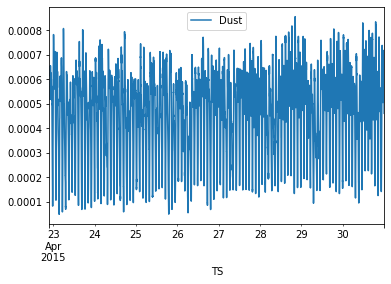

In [208]:
test1=test.rolling(window=30).mean()
test1.plot()

In [209]:
forecast = pd.Series(forecast, index=test.index).rename('Arima')

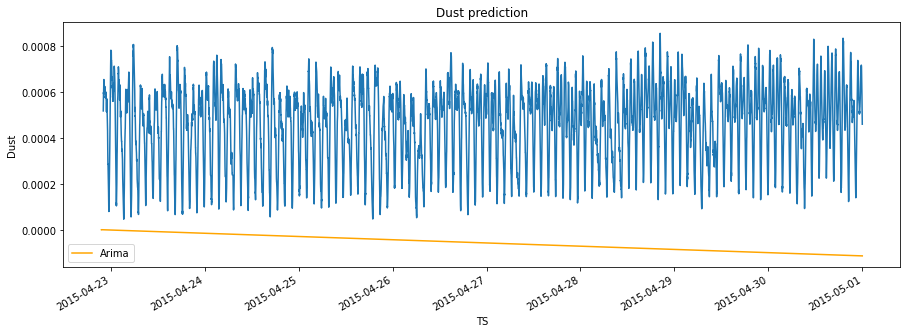

In [210]:


#plot 
fig, ax = plt.subplots(figsize =(15,5))
chart = sns.lineplot(x='TS',y='Dust', data=test1)
chart.set_title('Dust prediction')
forecast.plot(ax=ax, color='orange', legend=True)

In [202]:
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

for param in pdq:
    try:
        model = ARIMA(train['Dust'], order=param)
        model_fit = model.fit()
        print(param, model_fit.aic)
    except:
        continue

(0, 0, 0) -381428.16606077284
(0, 0, 1) -391256.5453121403
(0, 0, 2) -394886.0153443502
(0, 0, 3) -397783.134659513
(0, 0, 4) -398672.9146179953
(0, 1, 0) -393762.5950416355
(0, 1, 1) -400989.00807252096
(0, 1, 2) -401748.8184897074
(0, 1, 3) -401746.7613985747
(0, 1, 4) -402140.1418260619
(0, 2, 0) -363901.621627239


C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


(0, 2, 1) -393699.0167322342


C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


(0, 2, 2) -396518.37717323157
(0, 2, 3) -396410.0602568809
(0, 2, 4) -393399.22331111284
(1, 0, 0) -398854.2045968576
(1, 0, 1) -402977.82331922516
(1, 0, 2) -402980.2967430164
(1, 0, 3) -402999.62448872445
(1, 0, 4) -402998.9994039522
(1, 1, 0) -399230.927086959
(1, 1, 1) -402140.59138299257


C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


(1, 1, 2) -402146.1567313856


C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


(1, 1, 3) -402143.75307223375
(1, 1, 4) -402156.5244042453
(1, 2, 0) -378629.1599498158


C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


(1, 2, 3) -401703.88754899526
(2, 0, 0) -401625.95834203664
(2, 0, 1) -402979.8908885984
(2, 0, 2) -403010.59933486517
(2, 0, 3) -403018.82219165214
(2, 0, 4) -403018.51939817506
(2, 1, 0) -401161.16154536686
(2, 1, 1) -402098.18686841696


C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


(2, 1, 2) -402143.71853167075


C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


(2, 1, 3) -402127.14579990134
(2, 1, 4) -402181.27910064533


C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


(2, 2, 0) -386573.4818245121
(3, 0, 0) -402685.89955147024
(3, 0, 1) -402995.0312801225
(3, 0, 2) -403019.4167279101


C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


(3, 0, 3) -403016.7168519205
(3, 0, 4) -403140.8369242076
(3, 1, 0) -401536.7643948974
(3, 1, 1) -402134.16236478393
(3, 1, 2) -402174.16242448415


C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


(3, 1, 3) -402172.2453509356


C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


(3, 1, 4) -402168.55496347847


C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


(3, 2, 0) -389788.07431473845


C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


(3, 2, 4) -401669.75445914315
(4, 0, 0) -402810.34613681573
(4, 0, 1) -402995.9118220251
(4, 0, 2) -403020.5730903869
(4, 0, 3) -403140.3896671269


C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


(4, 0, 4) -403395.19108467497
(4, 1, 0) -402068.50105264643
(4, 1, 1) -402220.9545955309
(4, 1, 2) -402213.8116601426
(4, 1, 3) -402215.37451930554


C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


(4, 1, 4) -402233.25197341526


C:\Users\zhouz\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


(4, 2, 0) -392495.6695254224


In [220]:
#attempt 2
model2=ARIMA(train['Dust'],order=(3,0,4))
model2=model2.fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Dust   No. Observations:                28656
Model:                     ARMA(3, 4)   Log Likelihood              201579.418
Method:                       css-mle   S.D. of innovations              0.000
Date:                Mon, 10 May 2021   AIC                        -403140.837
Time:                        20:42:46   BIC                        -403066.469
Sample:                    04-03-2015   HQIC                       -403116.923
                         - 04-22-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005   8.49e-06     60.178      0.000       0.000       0.001
ar.L1.Dust    -0.2989      0.015    -20.326      0.000      -0.328      -0.270
ar.L2.Dust     0.2147      0.010     22.232      0.000       0.196       0.234
ar.L3.Dust     0.8749      0.011     80.932      0.000       0.854       0.896
ma.L1.Dust     0.6922      0.016     43.800      0.000       0.661       0.723
ma.L2.Dust     0.2463      0.012     21.017      0.000       0.223       0.269
ma.L3.Dust    -0.5060      0.011    -46.667      0.000      -0.527      -0.485
ma.L4.Dust    -0.0212      0.007     -3.209      0.001      -0.034      -0.008
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6581           -0.7965j            1.0332           -0.3599
AR.2           -0.6581           +0.7965j            1.0332            0.3599
AR.3            1.0707           -0.0000j            1.0707           -0.0000
MA.1           -0.6696           -0.8072j            1.0487           -0.3602
MA.2           -0.6696           +0.8072j            1.0487            0.3602
MA.3            1.7652           -0.0000j            1.7652           -0.0000
MA.4          -24.3087           -0.0000j           24.3087           -0.5000
-----------------------------------------------------------------------------
"""

In [221]:
forecast2 = model2.forecast(steps=11663)[0]
forecast2

array([8.47631387e-05, 9.73000567e-05, 1.36571912e-04, ...,
       5.10784200e-04, 5.10784200e-04, 5.10784200e-04])

In [241]:
print('RMSE:', np.sqrt(mean_squared_error(test,forecast2)))
print('MSE:', mean_squared_error(test,forecast2))


RMSE: 0.00032722634820372894
MSE: 1.0707708295874806e-07


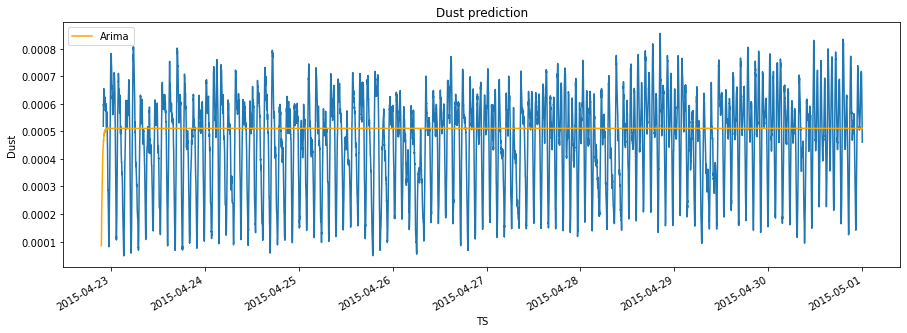

In [223]:
forecast2 = pd.Series(forecast2, index=test.index).rename('Arima')
#plot 
fig, ax = plt.subplots(figsize =(15,5))
chart = sns.lineplot(x='TS',y='Dust', data=test1)
chart.set_title('Dust prediction')
forecast2.plot(ax=ax, color='orange', legend=True)

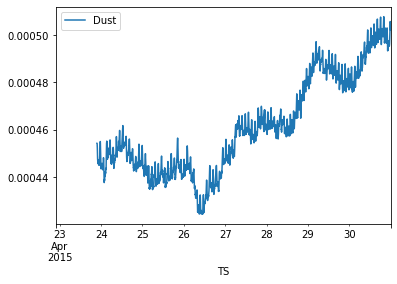

In [228]:
test2=test.rolling(window=1440).mean()
test2.plot()

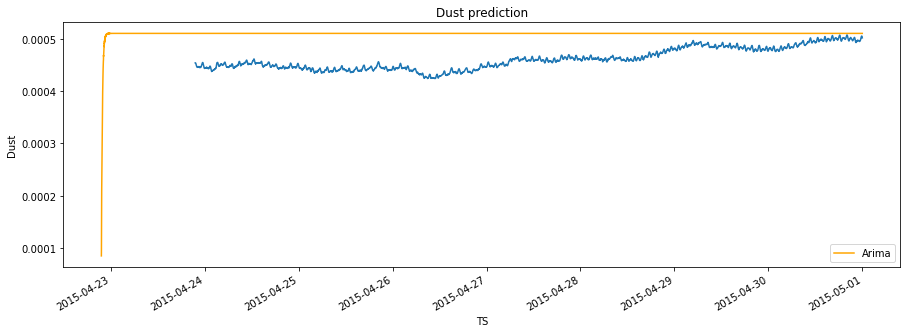

In [229]:
forecast2 = pd.Series(forecast2, index=test.index).rename('Arima')
#plot 
fig, ax = plt.subplots(figsize =(15,5))
chart = sns.lineplot(x='TS',y='Dust', data=test2)
chart.set_title('Dust prediction')
forecast2.plot(ax=ax, color='orange', legend=True)

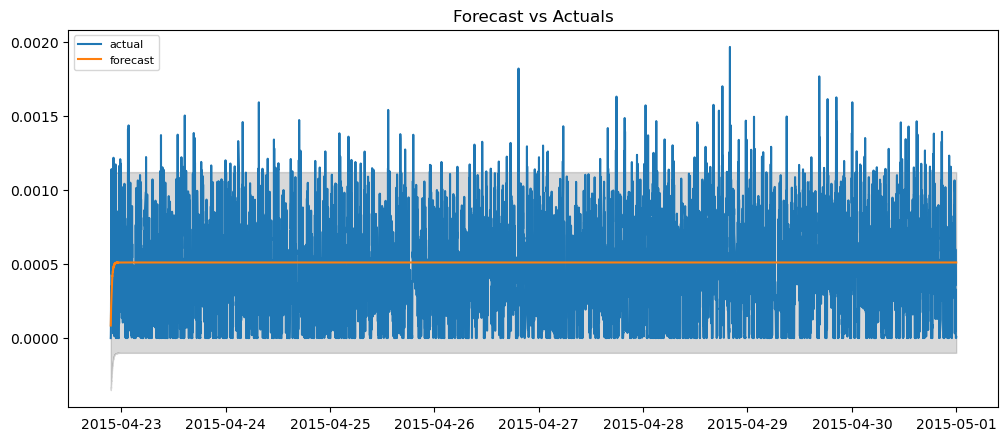

In [251]:
# Forecast
fc, se, conf = model2.forecast(11663, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(forecast2, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()